## Reading the midi File and finding the chords

In [2]:
import music21 as ms

In [3]:
mfile = ms.converter.parse('haydn_cmaj.mid')

In [4]:
mChords = mfile.chordify()

In [5]:
chordList = []
chordVectors = []
for c in mChords.recurse().getElementsByClass('Chord'):
    chordList.append(c.orderedPitchClasses)
    chordVectors.append(c.intervalVector)

In [6]:
def removeNonConnected(l1, l2):
    nl1 = l1
    nl2 = []
    j = 0
    for i in l2:
        if (
           sum(i) - 2*(i[2] + i[3] + i[4]) < 0 
        ):
            nl2.append(i)
            j += 1
        else :
            del nl1[j]            
    return nl1, nl2

In [7]:
chordListConnect, vectorsListConnect = removeNonConnected(chordList, chordVectors)

In [32]:
import ast
def removeDoubles(l):
    N = len(l)
    nl = []
    sl = [str(i) for i in l]
    nl.append(l[0])
    for i in range(1,N):
        if sl[i] != sl[i-1]:
           nl.append(ast.literal_eval(sl[i]))
    return nl

In [33]:
chordListConnectNoDoubles = removeDoubles(chordListConnect)

In [34]:
len(chordListConnect), len(chordListConnectNoDoubles) 

(1795, 512)

## Trajectory Calculations

In [11]:
def distanceIf(num, axes):
    point = (0, 0)
    if num == 0:
        point = (axes[0], axes[1])
    elif num == 3:
        point = (axes[0], axes[1]+1)
    elif num == 4:
        point = (axes[0] + 1, axes[1])
    elif num == 5:
        point = (axes[0]-1, axes[1]-1)
    elif num == 7:
        point = (axes[0]+1, axes[1]+1)
    elif num == 8:
        point = (axes[0] - 1, axes[1])
    elif num == 9:
        point = (axes[0], axes[1] - 1)
    else :
        point = (104, 104)
    return point

In [12]:
ChordX = [0, 4, 7]
CoordinatesOfTheFirstNote = (0 , 0)

In [13]:
import itertools as itt
def ChordConfiguration(chord, axes):
    if axes == (104,104):
        print(chord,axes)
        raise ValueError("Bad reference point")
    coordDict = {chord[0]: axes}
    n = 0
    while(len(chord) > len(coordDict)):
        for noteA, noteB in itt.product(chord,chord):
            if(noteA in coordDict and noteB not in coordDict):
                newPoint = distanceIf((noteB-noteA)%12, coordDict[noteA])
                if(newPoint != (104,104)):
                    coordDict[noteB]=newPoint
            if(n>len(chord)):
                print(chord,coordDict.items(),axes,n,len(chord),len(coordDict))
                raise RuntimeError("Infinite Loop")
        n += 1
    if(any(note not in coordDict for note in chord)):
         print(chord,coordDict.items(),axes)
         raise BaseException("Lost chord")
    return coordDict

In [14]:
def check(stringVec):
    value = 0
    if stringVec == "<000000>" :
        value = 0
    elif stringVec == "<001000>" : 
        value = 1
    elif stringVec == "<000100>" : 
        value = 1
    elif stringVec == "<000010>" : 
        value = 1
    else : 
        value = 2
    return value

In [15]:
def distNoteFromChord(chord, note):
    distanceValueList = [ 
            check((ms.chord.Chord([i, note])).intervalVectorString) for i in chord
        ]
    return distanceValueList

In [16]:
def IndexOfCloserNote(chord, note): 
    valueList = distNoteFromChord(chord, note)
    minimumIndex = valueList.index(min(valueList))
    return minimumIndex

In [17]:
def positionFromMin(chord, note, coordDict):
    keyIndex = IndexOfCloserNote(chord, note)
    noteA = chord[keyIndex]
    number = (note - noteA)%12
    position = coordDict[noteA]
    newPoint = distanceIf(number, position)
    return newPoint

In [18]:
def chordMatrix(Chord1, Chord2):
    m2 = [
            ([ (check((ms.chord.Chord([i, j])).intervalVectorString)) for i in Chord1 ]) for j in Chord2
         ]
    return m2

In [19]:
def distance_matrix(chord1, chord2):
    matrix = chordMatrix(chord1, chord2)
    l1=[sum([row[i] for row in matrix]) for i in range(len(chord1))]
    l2=list(map(sum, matrix))
    return l1, l2

In [20]:
def IndexesOfMinimum(chord1, chord2):
    l1, l2 = distance_matrix(chord1, chord2)
    min1 = min(l1)
    min2 = min(l2)
    minimumIndex1 = l1.index(min1)
    minimumIndex2 = l2.index(min2)
    distValue = check((ms.chord.Chord([chord1[minimumIndex1], chord2[minimumIndex2]])).intervalVectorString)
    if distValue > 1 : 
        listOfMinIndices1 = [i for i, n in enumerate(l1) if n > min1-2]
        listOfMinIndices2 = [i for i, n in enumerate(l2) if n > min2-2]
        minCheck = 2
        for i in listOfMinIndices1:
            for j in listOfMinIndices2:
                distVal = check((ms.chord.Chord([chord1[i], chord2[j]])).intervalVectorString)
                if  distVal < minCheck:
                    minimumIndex1 = i
                    minimumIndex2 = j                                        
    return minimumIndex1, minimumIndex2

In [21]:
def positionOfTheMinNote(chord1, chord2, coordDict1):
    index1, index2 = IndexesOfMinimum(chord1, chord2)
    noteA = chord1[index1]
    noteB = chord2[index2]
    chord2[0],chord2[index2] = chord2[index2],chord2[0]
    interval = (noteB - noteA)%12
    position = coordDict1[noteA]
    newPoint = distanceIf(interval, position)
    if newPoint == (104,104):
        print(chord1, chord2, coordDict1,noteA, noteB)
        raise RuntimeError("Couldn't match closest points")
    return newPoint  

In [22]:
ChordX = [0, 4, 7]
ChordY = [0, 2, 5, 9]
coordinatesOfTheFirstNote = (0 , 0)
coordDict1 = ChordConfiguration(ChordX, CoordinatesOfTheFirstNote)
coordDict2 = ChordConfiguration(ChordY, positionOfTheMinNote(ChordX, ChordY, coordDict1))


In [23]:
def Trajectory(listofChords, axes) :
    ListOfDict = []
    for index, chord in enumerate(listofChords):
        if index == 0 :
            ListOfDict.append(ChordConfiguration(chord, axes))
        else :
            axes = positionOfTheMinNote(listofChords[index-1], chord, ListOfDict[index-1])
            ListOfDict.append(ChordConfiguration(chord, axes))
    return ListOfDict
        

In [35]:
TrajectoryPoints = Trajectory(chordListConnectNoDoubles, (0,0))

### Let's plot that!

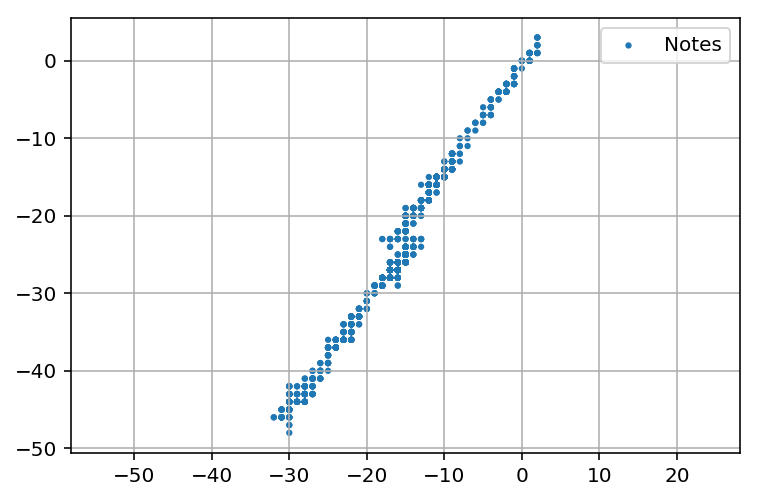

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.axis('equal')

axeX = []
axeY = []

for dicts in TrajectoryPoints:
    for el in dicts:
        x, y = dicts[el]
        axeX.append(x)
        axeY.append(y)
    
    
ax.scatter(axeX, axeY, c='tab:blue', s=10, label='Notes', alpha=1, edgecolors='none')

ax.legend()
ax.grid(True)


plt.show()

In [22]:
len(chordListConnect), chordListConnect

(14,
 [[0, 4, 7],
  [0, 5, 9],
  [0, 2, 6, 9],
  [0, 3, 7, 8],
  [7, 2, 11],
  [7, 3, 0],
  [0, 4, 7],
  [9, 5, 2],
  [5, 1, 8],
  [0, 4, 9],
  [0, 2, 5, 8],
  [2, 7, 11],
  [2, 5, 7, 11],
  [7, 4, 0]])

In [ ]:
IndexesOfMinimum1([4, 0, 7], [2, 5])